In [34]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import applications
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [35]:
# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = '/home/mksnkv/models/top_tuned/bottleneck_fc_model_passport_2class_mobilenetV2.h5'
train_data_dir = '/home/mksnkv/Documents/classification/passport_2class_divided_small/train'
validation_data_dir = '/home/mksnkv/Documents/classification/passport_2class_divided_small/validation'
evaluation_data_dir = '/home/mksnkv/Documents/classification/passport_2class_divided_small/evaluation'
nb_train_samples = 1000
nb_validation_samples = 300
nb_evaluation_samples = 560
epochs = 100
batch_size = 20

In [36]:
def save_bottleneck_features():
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    
    val_datagen = ImageDataGenerator(rescale=1. / 255)

    # build the MobileNetV2 network
    model = applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3), alpha=1.0, include_top=False, weights='imagenet')

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        train_generator, nb_train_samples // batch_size)
    np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

    val_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        val_generator, nb_validation_samples // batch_size)
    np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)

In [73]:
def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    train_labels = np.array(
        [0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

    validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array(
        [0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    adam = optimizers.Adam(learning_rate=1.0e-7)
    model.compile(optimizer=adam,
                  loss='binary_crossentropy', metrics=['accuracy'])
    
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
    reduce_lr_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')
    mcp_save = ModelCheckpoint(top_model_weights_path, save_best_only=True, monitor='val_loss', mode='min')
    log = TensorBoard(log_dir='logs')
    history = model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              callbacks = [reduce_lr_acc, earlyStopping, mcp_save, log],
              validation_data=(validation_data, validation_labels))
    return model, history

In [41]:
def plot(model, history):
    plot_model(model, to_file='model.png')
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [28]:
save_bottleneck_features()

Found 1000 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [74]:
model, history = train_top_model()

Train on 1000 samples, validate on 300 samples
Epoch 1/100
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.8392 - accuracy: 0.5890 - val_loss: 0.6197 - val_accuracy: 0.6600
Epoch 2/100
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.8146 - accuracy: 0.5930 - val_loss: 0.5798 - val_accuracy: 0.6933
Epoch 3/100
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.7482 - accuracy: 0.6190 - val_loss: 0.5481 - val_accuracy: 0.7367
Epoch 4/100
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.7194 - accuracy: 0.6250 - val_loss: 0.5224 - val_accuracy: 0.7600
Epoch 5/100
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.6864 - accuracy: 0.6530 - val_loss: 0.4992 - val_accuracy: 0.7867
Epoch 6/100
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.6438 - accuracy: 0.6630 - val_loss: 0.4781 - val_accuracy: 0.8133
Epoch 7/100
1000/1000 [==============================] - 3s 3ms/sample 

Epoch 55/100
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.1876 - accuracy: 0.9300 - val_loss: 0.1816 - val_accuracy: 0.9467
Epoch 56/100
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.1906 - accuracy: 0.9320 - val_loss: 0.1815 - val_accuracy: 0.9467
Epoch 57/100
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.1800 - accuracy: 0.9350 - val_loss: 0.1813 - val_accuracy: 0.9467
Epoch 58/100
 980/1000 [============================>.] - ETA: 0s - loss: 0.1766 - accuracy: 0.9286
Epoch 00058: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.1744 - accuracy: 0.9300 - val_loss: 0.1812 - val_accuracy: 0.9467
Epoch 59/100
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.1796 - accuracy: 0.9450 - val_loss: 0.1811 - val_accuracy: 0.9467
Epoch 60/100
1000/1000 [==============================] - 3s 3ms/sample - loss: 0.1908 - accu

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


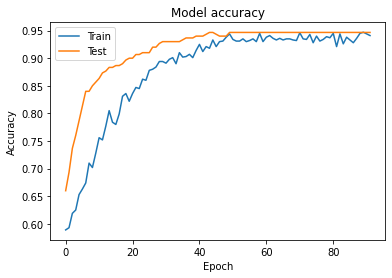

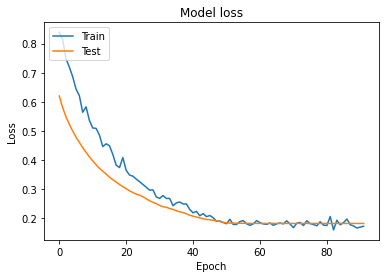

In [75]:
plot(model, history)

In [76]:
def evaluation(model):
    datagen = ImageDataGenerator(rescale=1. / 255)
    generator = datagen.flow_from_directory(
        evaluation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    model1 = applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet')
    features = model1.predict_generator(
        generator, nb_evaluation_samples // batch_size)
    return features

In [77]:
model.load_weights(top_model_weights_path)
features = evaluation(model)

Found 560 images belonging to 2 classes.


In [79]:
evaluation_labels = np.array(
        [0] * (nb_evaluation_samples // 2) + [1] * (nb_evaluation_samples // 2))
model.test_on_batch(features, evaluation_labels)

[0.20334046, 0.9375]

In [72]:
model.predict_on_batch(features)

<tf.Tensor: id=117995, shape=(560, 1), dtype=float32, numpy=
array([[0.02088761],
       [0.05212319],
       [0.07428256],
       [0.08008376],
       [0.03026316],
       [0.03174841],
       [0.57453305],
       [0.02176929],
       [0.02802703],
       [0.01611578],
       [0.02234143],
       [0.04518199],
       [0.04498175],
       [0.01292521],
       [0.0451206 ],
       [0.01108354],
       [0.08215159],
       [0.03944662],
       [0.6437536 ],
       [0.03517121],
       [0.05451849],
       [0.05313346],
       [0.02802703],
       [0.0454925 ],
       [0.16475809],
       [0.05864462],
       [0.04677725],
       [0.06962714],
       [0.03905416],
       [0.04469651],
       [0.04449126],
       [0.03744471],
       [0.0236468 ],
       [0.31990033],
       [0.05138612],
       [0.01794985],
       [0.04582691],
       [0.01426211],
       [0.01567459],
       [0.03658205],
       [0.9269022 ],
       [0.04766592],
       [0.02201891],
       [0.2229869 ],
       [0.03903